<a href="https://colab.research.google.com/github/EugIva/ProzorovEI209M_CV/blob/main/HW4_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Дз4 Задача №2 -**
 Найти шаблон на изображении с помощью HOG и кросс-корреляции   

Ваша задача - написать программу, которая сможет найти шаблон одного глаза (eye.png) на нескольких изображениях (eyes.jpg, eyes_dark.jpg, woman.jpg), в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure


In [21]:

# Вычисляет HOG-дескриптор для изображения и возвращает дескриптор и визуализированное изображение HOG.
def compute_hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                         cells_per_block=cells_per_block, block_norm=block_norm, visualize=True)
    return fd, hog_image

# Для каждого окна вычисляет кросс-корреляцию между дескриптором окна и дескриптором шаблона.
def find_best_match(image, template_fd, template_size, step=8):
    image_fd, _ = compute_hog(image)
    image_fd = image_fd.reshape((image.shape[0] // 8 - 1, image.shape[1] // 8 - 1, -1))

    best_match_location = (0, 0)
    best_match_value = -np.inf

    # Преобразуем дескрипторы в изображения для кросс-корреляции
    template_hog_image = template_fd.reshape(template_size[1] // 8 - 1, template_size[0] // 8 - 1, -1)
    image_hog_image = image_fd

    # Применяем кросс-корреляцию для каждого канала отдельно
    num_channels = template_hog_image.shape[2]
    results = []

    for channel in range(num_channels):
        template_channel = template_hog_image[:, :, channel]
        image_channel = image_hog_image[:, :, channel]

        # Нормализуем каналы
        template_channel = cv2.normalize(template_channel, None, 0, 1, cv2.NORM_MINMAX)
        image_channel = cv2.normalize(image_channel, None, 0, 1, cv2.NORM_MINMAX)

        # Преобразуем в тип CV_32F
        template_channel = template_channel.astype(np.float32)
        image_channel = image_channel.astype(np.float32)

        result = cv2.matchTemplate(image_channel, template_channel, cv2.TM_CCOEFF_NORMED)
        results.append(result)

    # Объединяем результаты
    final_result = np.mean(results, axis=0)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(final_result)

    best_match_location = (max_loc[0] * 8, max_loc[1] * 8)
    best_match_value = max_val

    return best_match_location, best_match_value

def draw_bounding_box(image, location, template_size):
    top_left = location
    bottom_right = (top_left[0] + template_size[0], top_left[1] + template_size[1])
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

def preprocess_image(image):
    # Увеличение контраста
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    # Удаление шума
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

# Масштабирует изображение на заданный коэффициент.
def scale_image(image, scale_factor):
    return cv2.resize(image, (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor)), interpolation=cv2.INTER_LINEAR)



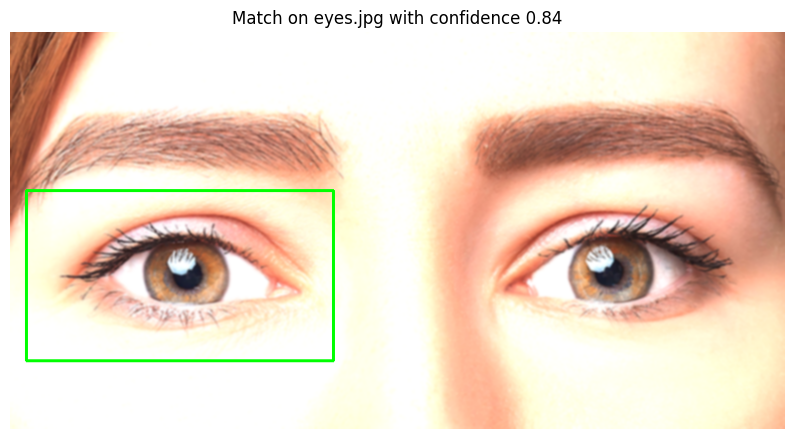

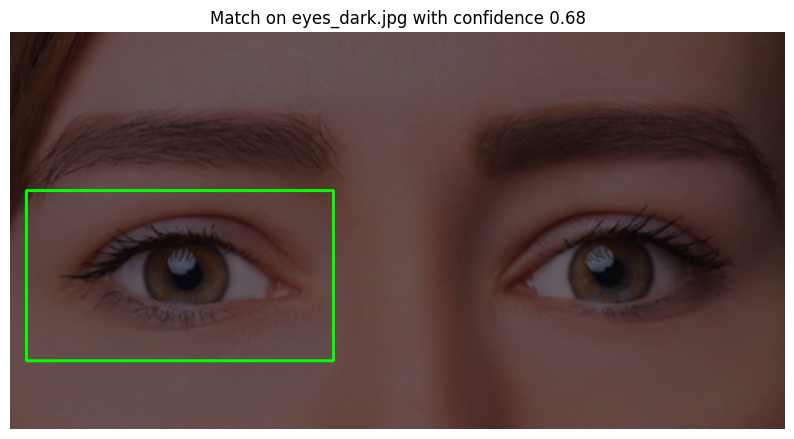

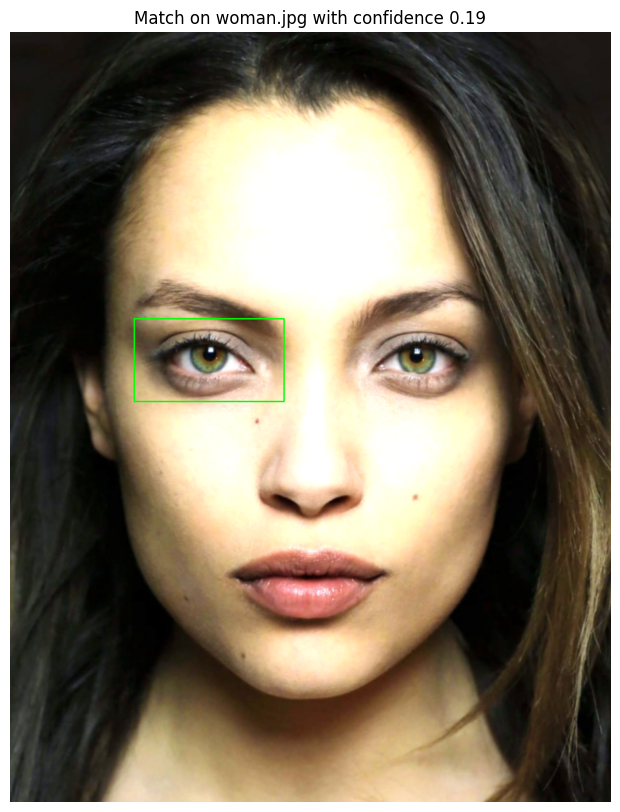

In [22]:
def main():
    # шаблон
    template = cv2.imread('eye.png')
    template = preprocess_image(template)
    template_fd, _ = compute_hog(template)

    images = ['eyes.jpg', 'eyes_dark.jpg', 'woman.jpg']

    for image_name in images:
        image = cv2.imread(image_name)
        image = preprocess_image(image)

        best_location = (0, 0)
        best_value = -np.inf

        # Попробуем разные масштабы
        for scale_factor in [0.8, 1.0, 1.2]:
            scaled_image = scale_image(image, scale_factor)
            location, value = find_best_match(scaled_image, template_fd, (template.shape[1], template.shape[0]))

            # Корректируем координаты для оригинального изображения
            location = (int(location[0] / scale_factor), int(location[1] / scale_factor))

            if value > best_value:
                best_value = value
                best_location = location

        # обрисовка
        draw_bounding_box(image, best_location, (template.shape[1], template.shape[0]))

        # отобразить
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Match on {image_name} with confidence {best_value:.2f}')
        plt.axis('off')
        plt.show()

if __name__ == "__main__":
    main()